In [1]:
import os
import sys
import numpy as np
import pandas as pd
import arviz as az

sys.path.append('../ga/mpi_scripts/')
from ina_model import InaModel
from io_utils import collect_results
from gene_utils import update_C_from_genes

sys.path.append('../MCMC/')
from functions import func_model
# from show_fig import show_fig
import matplotlib.pyplot as plt

from copy import deepcopy

In [2]:
trace_name = 'activation#1'
FOLDER_OUT = f'../results/pymc/activation/{trace_name}'

In [3]:
# For using gradient of trace, instead current trace: GRAD=True
# For log parameters: LOG=True

GRAD = 1
LOG = 1

In [4]:
# GA results config file dir
ga_case_dir = '../results/ga/activation#1/'
pd.DataFrame(os.listdir(ga_case_dir),
            columns=['case'])

,case
0,230709_021417
1,230709_115003


In [5]:
case = '230709_115003'

result = collect_results(case, ga_case_dir, dump_keys=['best'])
config = result['config']

experiment_condition_name = list(config['experimental_conditions'].keys())[-1]
# ga_phenotype_best = result['phenotype_best'][experiment_condition_name]

legend_states = config['runtime']['legend']['states']
legend_algebraic =  config['runtime']['legend']['algebraic'] 
legend_constants =  config['runtime']['legend']['constants']

In [6]:
df_protocol = config['experimental_conditions'][experiment_condition_name]['protocol']

filename_so = config['runtime']['filename_so_abs']
Ina = InaModel(filename_so)

experimental_phenotype = config['experimental_conditions'][experiment_condition_name]['phenotype']

A = deepcopy(legend_algebraic)
S = deepcopy(legend_states)

In [7]:
pass_params = ['alpha',
#                'c_m', 'R', 'g_max',
#                'x_c_comp', 'x_r_comp', 'tau_z',
#                'a0_m', 'b0_m', 's_m', 'delta_m', 'tau_m_const',
#                'a0_h', 'b0_h', 's_h', 'delta_h', 'tau_h_const',
#                'a0_j', 'b0_j', 's_j', 'delta_j', 'tau_j_const',
#                'v_half_m', 'k_m',
#                'v_half_h', 'k_h',
#                'v_rev', 'g_leak',
               ]
# prepare list of parameters for mcmc
# pass parameters will be taken from ga best result(sol_best) 
# other parameter will be default(from legend_constants) 
sol_best = result['sol_best']
C = deepcopy(legend_constants)
update_C_from_genes(C, sol_best, experiment_condition_name, config)
const_from_sol_best = deepcopy(C)
for param in const_from_sol_best.index:
    if param not in pass_params:
        const_from_sol_best[param] = legend_constants[param]
    
# delete pass parameters from m_index and sol_best_before by their number
m_index = config['runtime']['m_index']
mask_multipliers = config['runtime']['mask_multipliers']

delete_parameters = []
for param in pass_params:
    for condition_name in config['experimental_conditions']:
        if param in config['experimental_conditions'][condition_name]['params']:
            delete_index = (condition_name, param)
            param_number = np.where(m_index == delete_index)
            delete_parameters.append(param_number)
            
m_index = m_index.delete(delete_parameters)
sol_best_before = np.delete(sol_best.values, delete_parameters)
if LOG:
    mask_log = np.delete(mask_multipliers, delete_parameters)    
    for i, logic in enumerate(mask_log):
        if logic:
            sol_best_before[i] = np.log10(sol_best_before[i])

## SHOW RESULTS

In [8]:
#mcmc results dir
mcmc_results_dirname= '../results/pymc/activation/activation#1/'
pd.DataFrame(os.listdir(mcmc_results_dirname), 
             columns=['mcmc result name'])

,mcmc result name
0,230710_003238.nc
1,230710_002859.nc
2,230709_134321.nc


In [9]:
mcmc_result_filename = '230710_003238.nc' 
mcmc_result_path = os.path.join(mcmc_results_dirname, mcmc_result_filename)
mcmc_result = az.from_netcdf(mcmc_result_path)

In [10]:
full_len = mcmc_result.sample_stats.dims['chain'] * mcmc_result.sample_stats.dims['draw']
acceptance = mcmc_result.sample_stats.accepted.T[1].values.sum()/full_len
print(f'Acceptance rate = {acceptance*100}')

Acceptance rate = 0.75


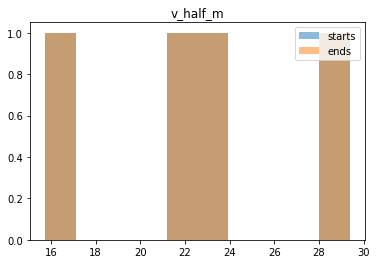

In [11]:
# shows hist of parameter starts and end

parameter_hist = 'v_half_m'
parameter_number = np.where(m_index.get_level_values(1) == parameter_hist)[0][0]
parameter_starts = list(np.array(mcmc_result.posterior.data_vars['parameters'].T[parameter_number][0]))
parameter_ends = list(np.array(mcmc_result.posterior.data_vars['parameters'].T[parameter_number][-1]))

plt.title(parameter_hist)
for data, label in zip([parameter_starts, parameter_ends],
                      ['starts', 'ends']):
    plt.hist(data, 
             label = label,  
             alpha = 0.5,
             bins = 10,
             range = [min(parameter_starts + parameter_ends),
                      max(parameter_starts + parameter_ends)
                     ]
            )
plt.legend()

In [12]:
chain_number = 2

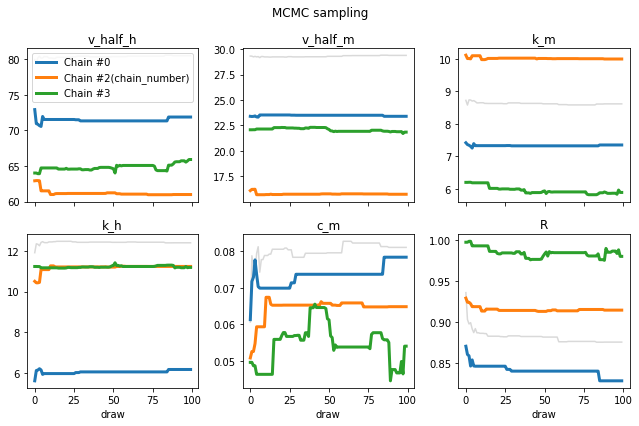

In [13]:
show_parameters = ['v_half_h', 'v_half_m','k_m', 'k_h', 'c_m', 'R']
show_parameters_ind = [np.where(m_index.get_level_values(1) == param)[0][0] for param in show_parameters]


nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols)*1.5,
                         sharex=True)

fig.suptitle('MCMC sampling')

for i_row in range(nrows):
    for i_col in range(ncols):
        
        abs_numb = i_row * ncols + i_col
        ind = show_parameters_ind[abs_numb]
        
        ax = axes[i_row, i_col]
        title = m_index.get_level_values(1)[ind]
        ax.set_title(title)
        

        ax.plot(mcmc_result.posterior.data_vars['parameters'].T[ind], 
                c = '0.85',
                )

        ax.plot(mcmc_result.posterior.data_vars['parameters'].T[ind][:, 0], 
                lw = 3, 
                c = 'C0',
                label = 'Chain #0')

        ax.plot(mcmc_result.posterior.data_vars['parameters'].T[ind][:, chain_number], 
                lw = 3, 
                c = 'C01',
                label = f'Chain #{chain_number}(chain_number)')

        ax.plot(mcmc_result.posterior.data_vars['parameters'].T[ind][:, -1], 
                lw = 3, 
                c = 'C02',
                label = f"Chain #{mcmc_result.sample_stats.dims['chain']-1}")

        if i_col == 0 and i_row == 0:
            ax.legend()
        if i_row == nrows-1:
            ax.set_xlabel('draw')
plt.tight_layout()

In [14]:
burn_end = 1

dict_chain = {}
dict_chain = {name:np.array(mcmc_result.posterior.data_vars['parameters'][chain_number, burn_end:, :].T[k]) 
             for k, name in enumerate(m_index.get_level_values(1))}


dict_all_chains = {}
dict_all_chains = {name:np.array(mcmc_result.posterior.data_vars['parameters'][:, burn_end:, :].T[k])
                  .reshape(-1) for k, name in enumerate(m_index.get_level_values(1))}

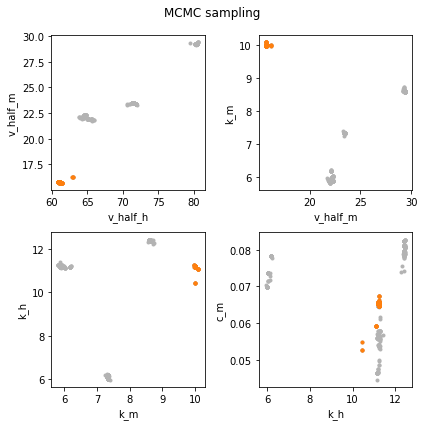

In [15]:
downs = 1
start = 0

background_color = 'w'
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols) * 1.5,
                        )

fig.suptitle('MCMC sampling')

for i_row in range(nrows):
    for i_col in range(ncols):
        abs_numb = i_row*ncols + i_col
        ax = axes[i_row, i_col]

        key_1 = m_index.get_level_values(1)[show_parameters_ind[abs_numb]]
        key_2 = m_index.get_level_values(1)[show_parameters_ind[abs_numb+1]]

        # show all data
        ax.plot(dict_all_chains[key_1], 
                dict_all_chains[key_2], 
                '.', 
                c = '0.7')
        # show chain_number
        ax.plot(dict_chain[key_1], 
                dict_chain[key_2], 
                '.', 
                c = 'C1')
        ax.set_xlabel(key_1)
        ax.set_ylabel(key_2)
plt.tight_layout()

/home/nik/miniconda3/envs/env_pypoptim/lib/python3.8/site-packages/arviz/plots/pairplot.py:242: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


array([[<AxesSubplot:ylabel='g_max'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='v_half_h'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='v_half_m'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='k_h'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='k_m'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='g_max', ylabel='g_leak'>,
        <AxesSubplot:xlabel='v_half_h'>, <AxesSubplot:xlabel='v_half_m'>,
        <AxesSubplot:xlabel='k_h'>, <AxesSubplot:xlabel='k_m'>,
        <AxesSubplot:xlabel='g_leak'>]], dtype=object)

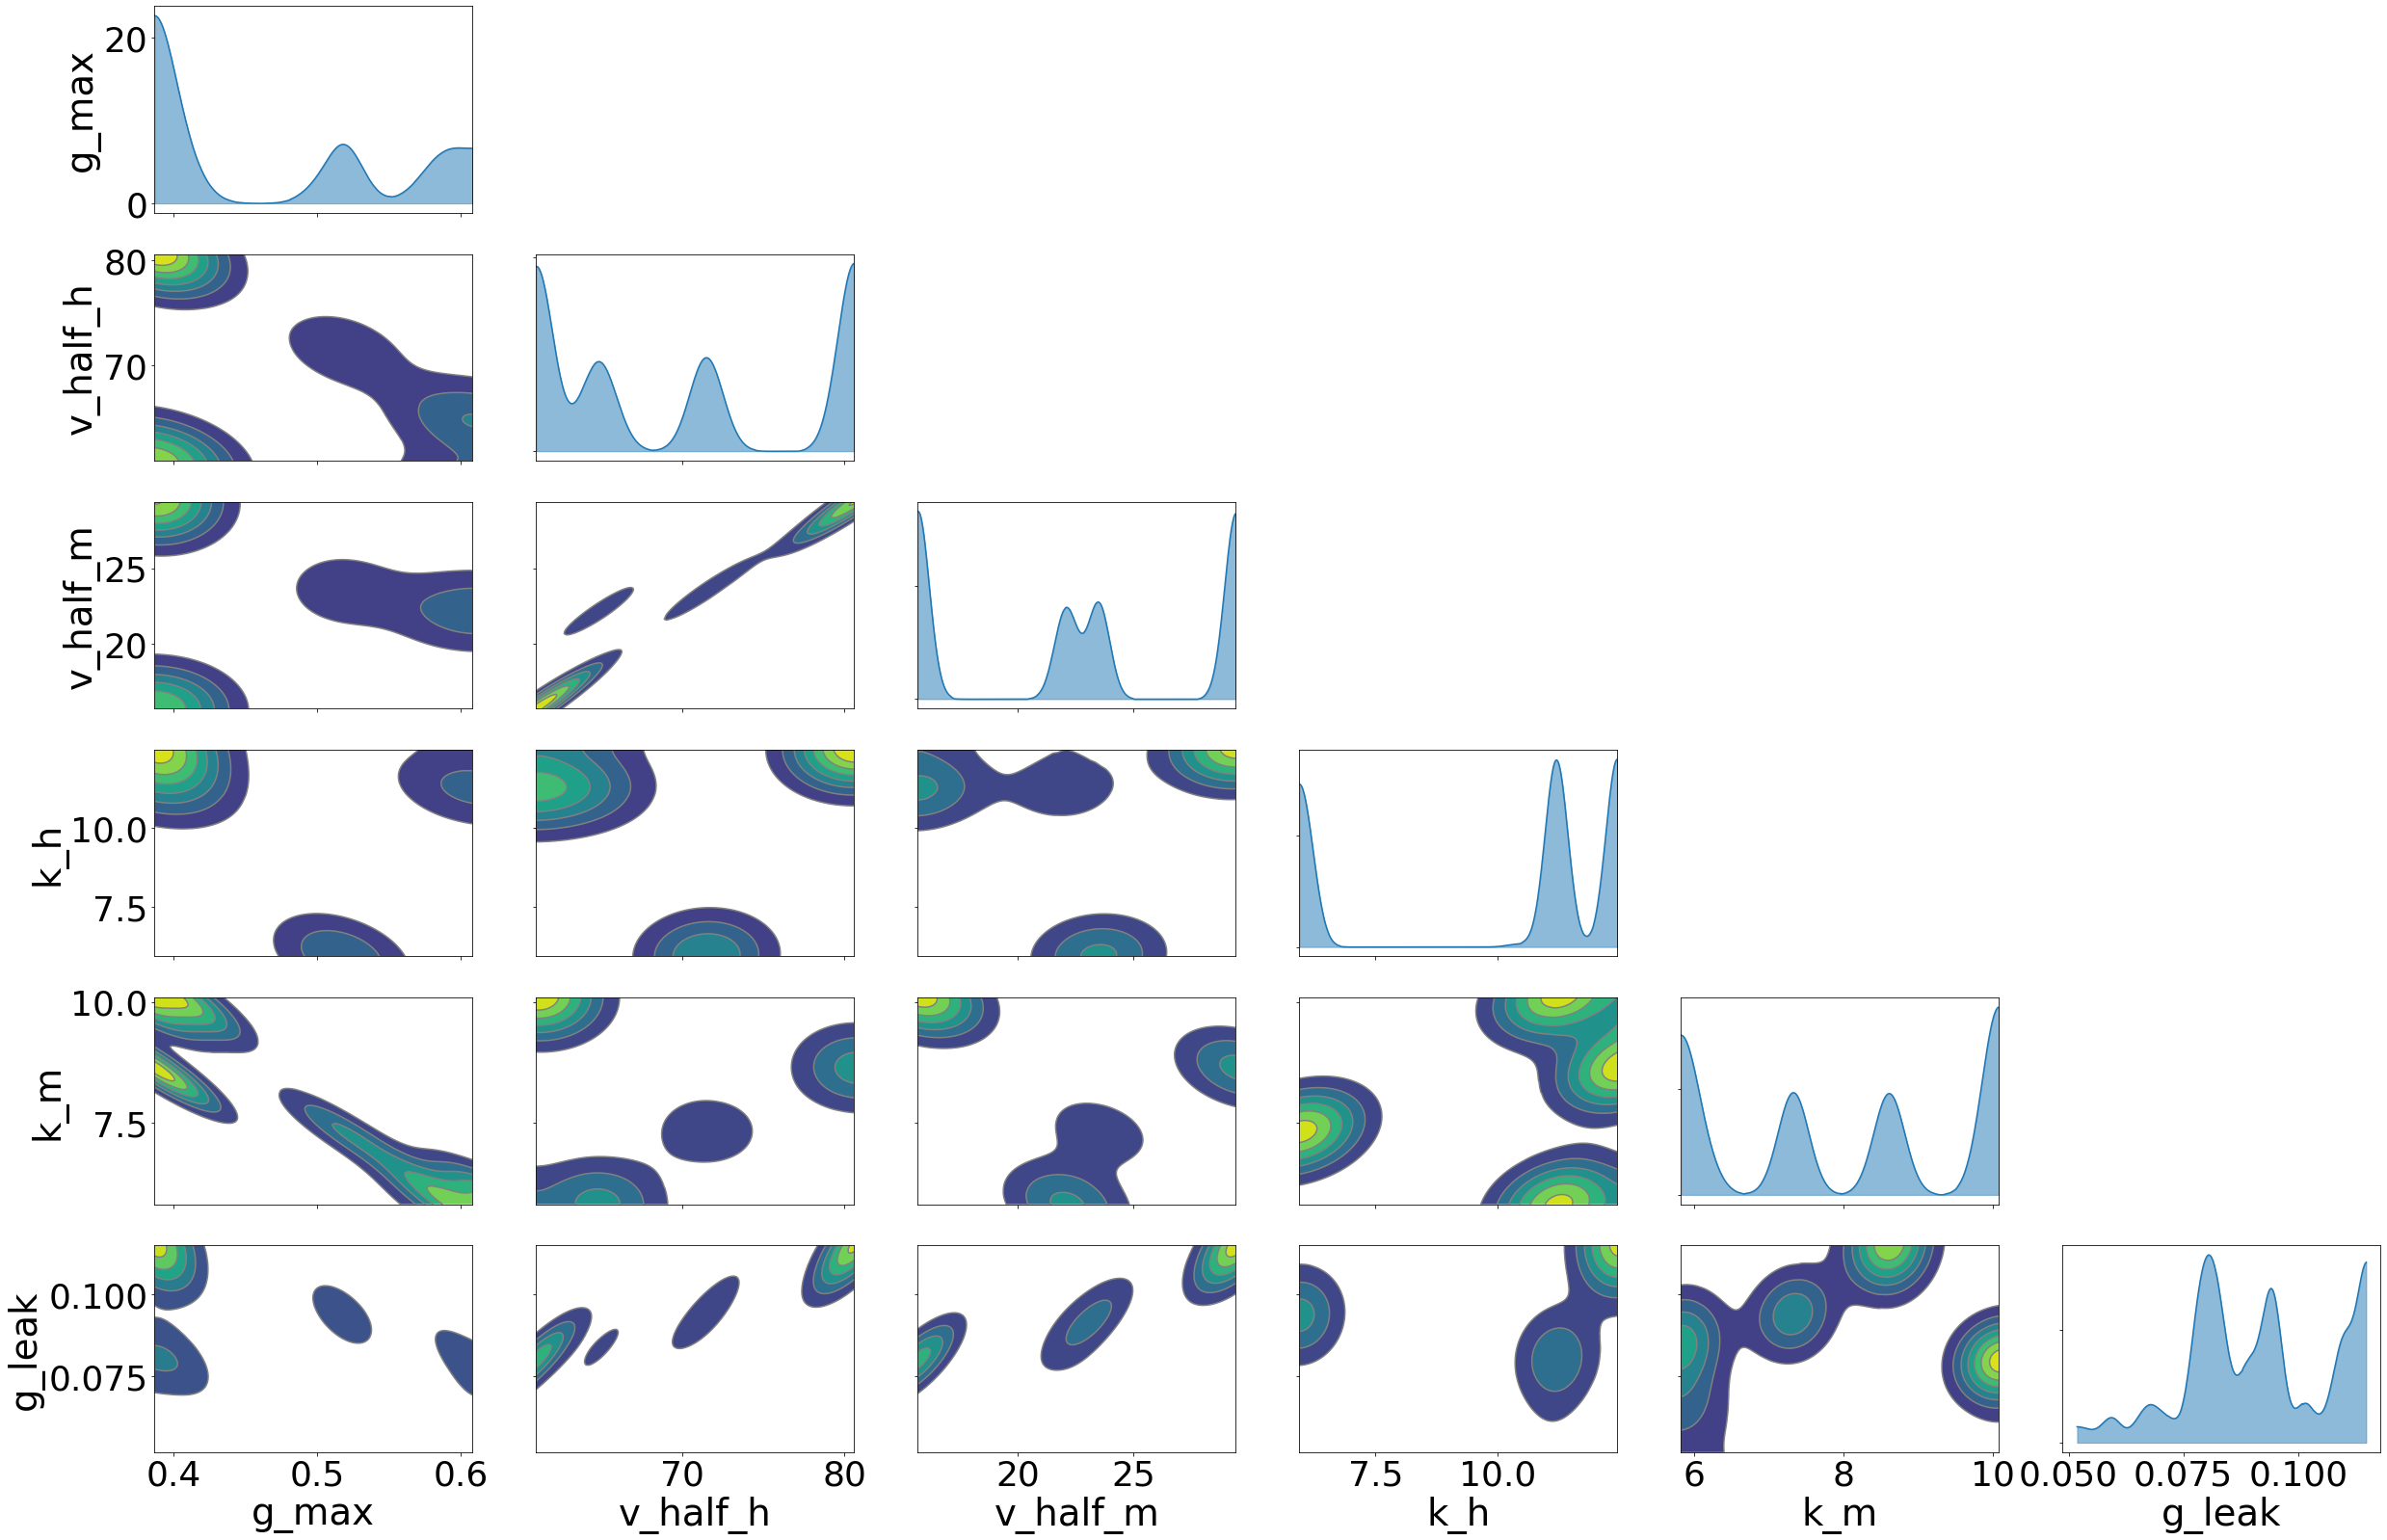

In [16]:
az.plot_pair(dict_all_chains,
             var_names=['g_max',
                        'v_half_h',
                        'v_half_m', 
                        'k_h',  
                        'k_m',
                        'g_leak'],

             kind='kde',
             marginals = True,
             divergences=True,  
             textsize=36,
             colorbar = True,
             kde_kwargs={'contour':1,
                         'bw':"scott",
                        },
             marginal_kwargs={'fill_kwargs':{'alpha': 0.5}}   
            )

In [17]:
sol_first = np.array(mcmc_result.posterior.data_vars['parameters'][chain_number][0])
n_center = mcmc_result.sample_stats.dims['draw']//2
sol_center =  np.array(mcmc_result.posterior.data_vars['parameters'][chain_number][n_center])
sol_last =  np.array(mcmc_result.posterior.data_vars['parameters'][chain_number][-1])


In [18]:
flag = 'ina'

first_res = func_model(sol_best_before, 
                       m_index, 
                       Ina=Ina, 
                       const=const_from_sol_best, 
                       config=config, 
                       flag = flag,
                       mask_log = mask_log
                      ) 
center_res = func_model(sol_center, 
                        m_index, 
                        Ina=Ina, 
                        const=const_from_sol_best, 
                        config=config, 
                        flag = flag,
                        mask_log = mask_log
                       ) 
last_res = func_model(sol_last, 
                      m_index, 
                      Ina=Ina, 
                      const=const_from_sol_best, 
                      config=config, 
                      flag = flag,
                      mask_log = mask_log
                     ) 


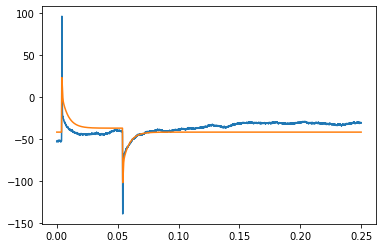

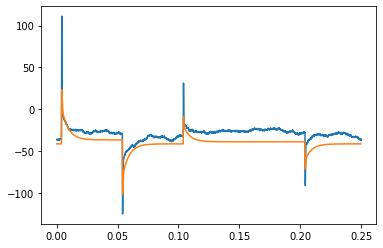

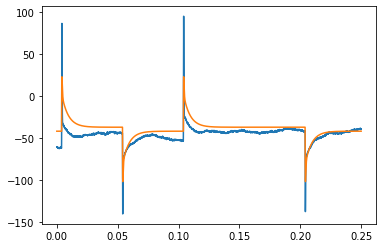

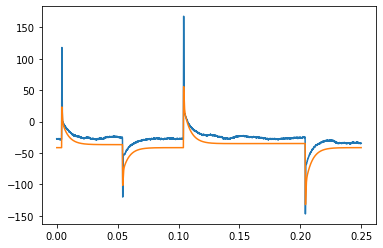

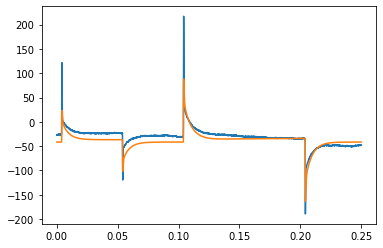

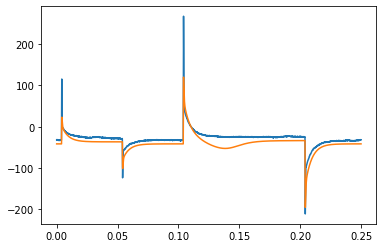

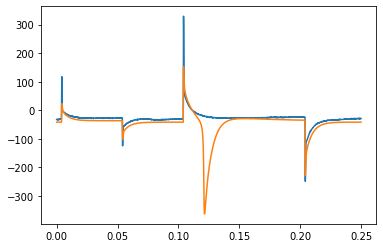

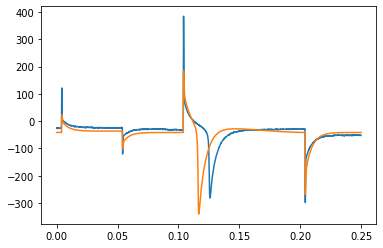

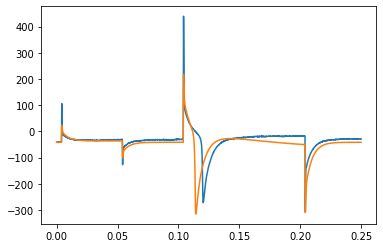

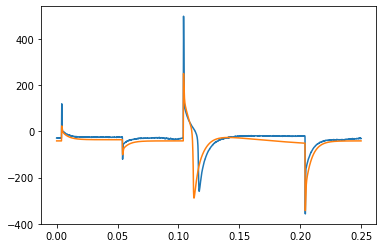

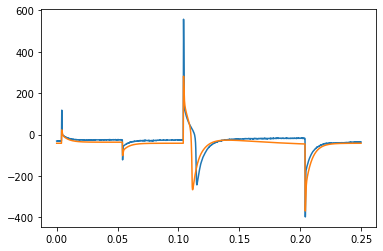

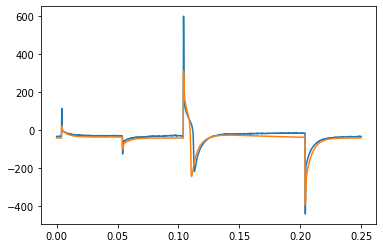

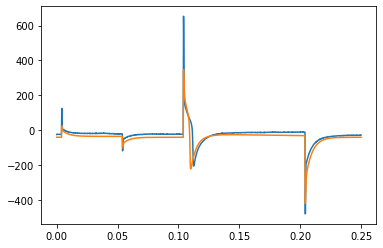

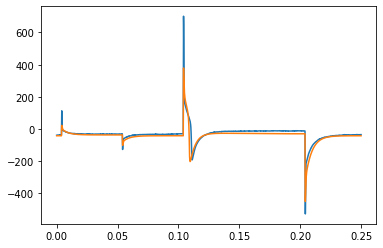

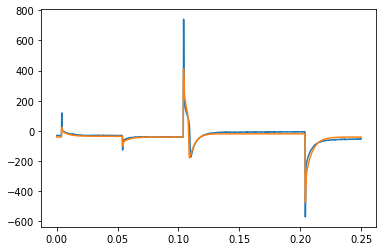

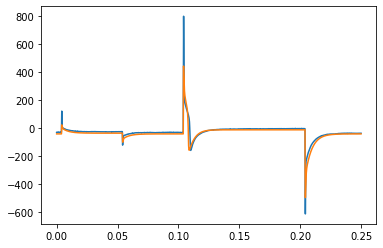

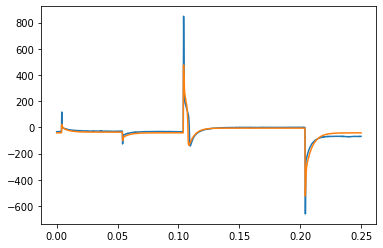

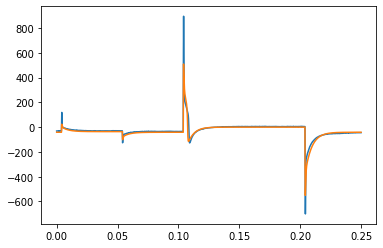

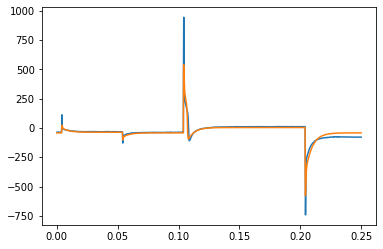

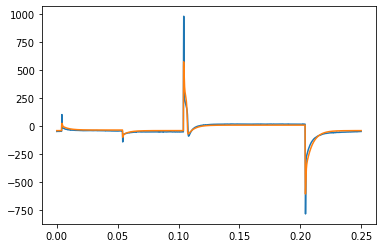

In [19]:
for i in range(df_protocol.shape[1]-1):
    plt.figure()
    plt.plot(df_protocol['t'], experimental_phenotype.reshape(-1, len(df_protocol))[i])
    plt.plot(df_protocol['t'], last_res.reshape(-1, len(df_protocol))[i])
#     plt.plot(df_protocol['t'], first_res.reshape(-1, len(df_protocol))[i])
#     plt.plot(df_protocol['t'], center_res.reshape(-1, len(df_protocol))[i])
    


## KDE several experiments

In [20]:
results_dir = '../results/pymc/activation/'

In [21]:
idatas_dicts = {}

burn_end  = 1
ind_keys = []
name_keys = [
#              'v_half_h', 'k_h', 
             'v_half_m', 'k_m', 
             ]

for name in name_keys:
    ind_key = np.where(m_index.get_level_values(1) == name)[0][0]
    ind_keys.append(ind_key)

for trace_dir in os.listdir(results_dir):
    cases_dir = os.path.join(results_dir, trace_dir)
    cases = os.listdir(cases_dir)
    
    idatas_dicts[trace_dir]= {}
    idata_keys = [[] for _ in range(len(ind_keys))]
    
    for case in cases:
        case_filename = os.path.join(cases_dir, case)
        idata = az.from_netcdf(case_filename)
        
        for k, key in enumerate(ind_keys):
            idata_keys[k].append(np.array(idata.posterior.data_vars['parameters'][:, burn_end:, key],
                                         ).reshape(-1))
    for k, key in enumerate(name_keys):
        idatas_dicts[trace_dir][key] = np.concatenate(idata_keys[k])

In [22]:
trace_keys = idatas_dicts.keys()
trace_keys

dict_keys(['activation#1'])

In [23]:
from sklearn.neighbors import KernelDensity

In [24]:
bandwidth = 1
kde_models = {}
for k, key in enumerate(idatas_dicts.keys()):
    kde_model = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde_model.fit(np.array([idatas_dicts[key].get(name) for name in name_keys]).T)
    kde_models[key] = kde_model

In [25]:
# grid for activation parameters
x = np.arange(0, 60, 1)# v_half_m
y = np.arange(0, 20, 0.5)# k_m

# # grid for inactivation parameters
# x = np.arange(30, 100, 1)# v_half_h
# y = np.arange(3, 15, 1)# k_h

x_grid, y_grid = np.meshgrid(x, y, )
x_grid = np.reshape(x_grid, -1)
y_grid = np.reshape(y_grid, -1)

In [26]:
show_kdes = {}
for k, key in enumerate(kde_models.keys()):
    kde_model = kde_models[key]
    show_kde = kde_model.score_samples(np.array([x_grid, y_grid]).T)
    show_kde = np.reshape(show_kde, [len(y), len(x)])
    show_kdes[key] = show_kde

In [27]:
# @decorator(*v_mu_sigma)
def dist(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

In [28]:
# posterior distribution bounds
bounds_v = [-10., 60.]
bounds_k = [3., 20.]

def mu_sigma(bounds):
    mu = (bounds[1]+bounds[0])/2
    sigma=(bounds[1]-bounds[0])*2.
    return [mu, sigma]

v_mu_sigma = mu_sigma(bounds_v)
k_mu_sigma = mu_sigma(bounds_k)

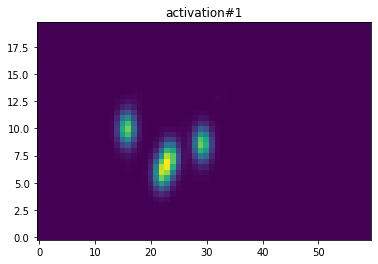

In [29]:
for k, key in enumerate(show_kdes.keys()):
    plt.figure()
    plt.pcolor(x, y, np.exp(show_kdes[key]), shading = 'auto')
    plt.title(key)

In [30]:
exp_all = 1
for key in show_kdes:
    exp_all*=np.exp(show_kdes[key])

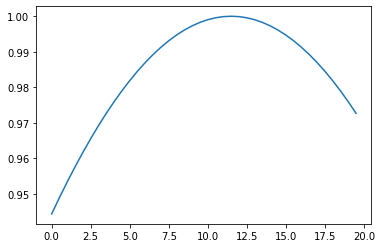

In [31]:
k_dist = np.array(list(map(lambda s: dist(s, *k_mu_sigma), y)))
v_dist = np.array(list(map(lambda s: dist(s, *v_mu_sigma), x)))

plt.plot(y, k_dist/max(k_dist))

In [32]:
exp_dist = exp_all.copy()
v_all = v_dist**len(show_kdes)
# v_all/=max(v_all)
k_all = k_dist**len(show_kdes)
# k_all/=max(k_all)
for i in range(np.shape(exp_all)[0]):
    exp_dist[i] /= v_all
for i in range(np.shape(exp_all)[1]):
    exp_dist.T[i] /= k_all

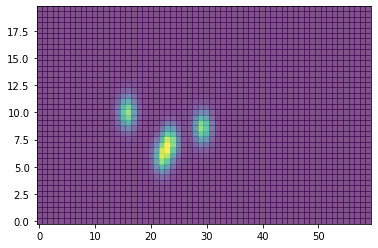

In [33]:
cfset = plt.pcolor(x, y, exp_dist/(np.max(exp_dist)-np.min(exp_dist)), shading = 'auto', alpha=0.2)
cfset = plt.pcolor(x, y, exp_all/(np.max(exp_all)-np.min(exp_all)), shading = 'auto', alpha=0.6)


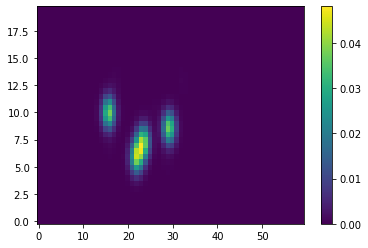

In [34]:
cfset = plt.pcolor(x, y, exp_all, shading = 'auto')
plt.colorbar(cfset)